In [1]:
# Connecting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Saving the data into memory for faster training
!unzip "/content/drive/MyDrive/MASTER_THESIS/Models/Dataset/Dataset.zip" -d "/content"

In [3]:
# Checking GPU
!nvidia-smi

Wed Nov 30 18:29:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install timm

In [5]:
import numpy as np 
import os

import timm 
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms as T 
from torchsummary import summary

import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sn 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
 
from tqdm import tqdm 
import time 
import copy
import warnings 
warnings.filterwarnings("ignore")

In [6]:
# Extracting all classes in the dataset
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [7]:
# Load and transform data
def get_data_loaders(data_dir, batch_size, train = False):
    if train: # Training data
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            T.RandomErasing(p=0.25, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)

    else: # Validation and test data
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "valid/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

In [8]:
dataset_path = "/content/Dataset"

In [9]:
(train_loader, train_data_len) = get_data_loaders(dataset_path, 32, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 32, train=False)

In [10]:
classes = get_classes("/content/Dataset/train")
print(classes, len(classes))

['MildDemented', 'ModerateDemented', 'NonDemented'] 3


In [11]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}

In [12]:
print(len(train_loader), len(val_loader), len(test_loader))

91 20 20


In [13]:
print(train_data_len, valid_data_len, test_data_len)

2911 623 626


In [14]:
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
# Create model
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)

Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_base_patch4_window7_224_22kto1k.pth


In [ ]:
# Aquiring the model keys to unfreeze
params = model.state_dict()
params.keys()

In [17]:
# Freezing model
for param in model.parameters():
    param.requires_grad = False

# Unfreezing the last SwinTransformer Block and layers after that
model.layers[3].blocks[1].norm1.weight.requires_grad = True
model.layers[3].blocks[1].norm1.bias.requires_grad = True
model.layers[3].blocks[1].attn.qkv.weight.requires_grad = True
model.layers[3].blocks[1].attn.qkv.bias.requires_grad = True
model.layers[3].blocks[1].attn.proj.weight.requires_grad = True
model.layers[3].blocks[1].attn.proj.bias.requires_grad = True
model.layers[3].blocks[1].norm2.weight.requires_grad = True
model.layers[3].blocks[1].norm2.bias.requires_grad = True
model.layers[3].blocks[1].mlp.fc1.weight.requires_grad = True
model.layers[3].blocks[1].mlp.fc1.bias.requires_grad = True
model.layers[3].blocks[1].mlp.fc2.weight.requires_grad = True
model.layers[3].blocks[1].mlp.fc2.bias.requires_grad = True
model.norm.weight.requires_grad = True
model.norm.bias.requires_grad = True


In [18]:
# Changing the classification head
n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)
model = model.to(device)
print(model.head)

Sequential(
  (0): Linear(in_features=1024, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=3, bias=True)
)


In [19]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 56, 56]           6,272
         LayerNorm-2            [-1, 3136, 128]             256
        PatchEmbed-3            [-1, 3136, 128]               0
           Dropout-4            [-1, 3136, 128]               0
         LayerNorm-5            [-1, 3136, 128]             256
            Linear-6              [-1, 49, 384]          49,536
           Softmax-7            [-1, 4, 49, 49]               0
           Dropout-8            [-1, 4, 49, 49]               0
            Linear-9              [-1, 49, 128]          16,512
          Dropout-10              [-1, 49, 128]               0
  WindowAttention-11              [-1, 49, 128]               0
         Identity-12            [-1, 3136, 128]               0
        LayerNorm-13            [-1, 3136, 128]             256
           Linear-14            [-1, 31

In [20]:
# Setting Hyperparameters
epochs = 50
weights = [3.5, 51, 1]
class_weights = torch.FloatTensor(weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)
criterion = criterion.to(device)

optimizer = optim.AdamW(model.head.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [21]:
# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [22]:
# Train model
model = train_model(model, criterion, optimizer, exp_lr_scheduler)

Epoch 0/49
----------


100%|██████████| 91/91 [00:34<00:00,  2.60it/s]


train Loss: 1.0636 Acc: 0.5771


100%|██████████| 20/20 [00:07<00:00,  2.70it/s]


val Loss: 0.7670 Acc: 0.7191

Epoch 1/49
----------


100%|██████████| 91/91 [00:35<00:00,  2.53it/s]


train Loss: 0.9068 Acc: 0.6699


100%|██████████| 20/20 [00:07<00:00,  2.60it/s]


val Loss: 0.5651 Acc: 0.7817

Epoch 2/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.50it/s]


train Loss: 0.7983 Acc: 0.6898


100%|██████████| 20/20 [00:07<00:00,  2.63it/s]


val Loss: 0.5906 Acc: 0.7673

Epoch 3/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.47it/s]


train Loss: 0.7853 Acc: 0.6805


100%|██████████| 20/20 [00:07<00:00,  2.55it/s]


val Loss: 0.4082 Acc: 0.8331

Epoch 4/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.46it/s]


train Loss: 0.6826 Acc: 0.7272


100%|██████████| 20/20 [00:07<00:00,  2.65it/s]


val Loss: 0.4478 Acc: 0.8074

Epoch 5/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.52it/s]


train Loss: 0.6614 Acc: 0.7283


100%|██████████| 20/20 [00:07<00:00,  2.63it/s]


val Loss: 0.6970 Acc: 0.6870

Epoch 6/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.49it/s]


train Loss: 0.6473 Acc: 0.7241


100%|██████████| 20/20 [00:07<00:00,  2.59it/s]


val Loss: 0.5214 Acc: 0.7673

Epoch 7/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.52it/s]


train Loss: 0.6055 Acc: 0.7499


100%|██████████| 20/20 [00:07<00:00,  2.60it/s]


val Loss: 0.5014 Acc: 0.7913

Epoch 8/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.6082 Acc: 0.7290


100%|██████████| 20/20 [00:08<00:00,  2.47it/s]


val Loss: 0.5415 Acc: 0.7657

Epoch 9/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.5697 Acc: 0.7485


100%|██████████| 20/20 [00:07<00:00,  2.58it/s]


val Loss: 0.6420 Acc: 0.7127

Epoch 10/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.5652 Acc: 0.7558


100%|██████████| 20/20 [00:07<00:00,  2.59it/s]


val Loss: 0.5160 Acc: 0.7576

Epoch 11/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.50it/s]


train Loss: 0.5715 Acc: 0.7451


100%|██████████| 20/20 [00:07<00:00,  2.59it/s]


val Loss: 0.4600 Acc: 0.7833

Epoch 12/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.4842 Acc: 0.7619


100%|██████████| 20/20 [00:07<00:00,  2.60it/s]


val Loss: 0.4536 Acc: 0.7913

Epoch 13/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.5313 Acc: 0.7551


100%|██████████| 20/20 [00:07<00:00,  2.60it/s]


val Loss: 0.3784 Acc: 0.8283

Epoch 14/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.50it/s]


train Loss: 0.5044 Acc: 0.7678


100%|██████████| 20/20 [00:07<00:00,  2.59it/s]


val Loss: 0.4467 Acc: 0.7673

Epoch 15/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.52it/s]


train Loss: 0.5291 Acc: 0.7633


100%|██████████| 20/20 [00:07<00:00,  2.58it/s]


val Loss: 0.4907 Acc: 0.7721

Epoch 16/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.4995 Acc: 0.7468


100%|██████████| 20/20 [00:07<00:00,  2.62it/s]


val Loss: 0.4329 Acc: 0.7849

Epoch 17/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.50it/s]


train Loss: 0.5159 Acc: 0.7764


100%|██████████| 20/20 [00:07<00:00,  2.58it/s]


val Loss: 0.5643 Acc: 0.7095

Epoch 18/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.4850 Acc: 0.7736


100%|██████████| 20/20 [00:07<00:00,  2.64it/s]


val Loss: 0.5161 Acc: 0.7448

Epoch 19/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.52it/s]


train Loss: 0.4788 Acc: 0.7698


100%|██████████| 20/20 [00:07<00:00,  2.58it/s]


val Loss: 0.4034 Acc: 0.8010

Epoch 20/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.48it/s]


train Loss: 0.5127 Acc: 0.7578


100%|██████████| 20/20 [00:07<00:00,  2.63it/s]


val Loss: 0.5885 Acc: 0.7464

Epoch 21/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.5171 Acc: 0.7661


100%|██████████| 20/20 [00:07<00:00,  2.62it/s]


val Loss: 0.5347 Acc: 0.7143

Epoch 22/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.50it/s]


train Loss: 0.4721 Acc: 0.7657


100%|██████████| 20/20 [00:07<00:00,  2.59it/s]


val Loss: 0.4433 Acc: 0.7865

Epoch 23/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.50it/s]


train Loss: 0.4469 Acc: 0.7688


100%|██████████| 20/20 [00:07<00:00,  2.59it/s]


val Loss: 0.3213 Acc: 0.8363

Epoch 24/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.4841 Acc: 0.7736


100%|██████████| 20/20 [00:07<00:00,  2.64it/s]


val Loss: 0.3756 Acc: 0.8202

Epoch 25/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.4681 Acc: 0.7795


100%|██████████| 20/20 [00:07<00:00,  2.59it/s]


val Loss: 0.3337 Acc: 0.8507

Epoch 26/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.5117 Acc: 0.7757


100%|██████████| 20/20 [00:07<00:00,  2.60it/s]


val Loss: 0.2839 Acc: 0.8636

Epoch 27/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.4860 Acc: 0.7764


100%|██████████| 20/20 [00:07<00:00,  2.58it/s]


val Loss: 0.3117 Acc: 0.8475

Epoch 28/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.4558 Acc: 0.7784


100%|██████████| 20/20 [00:07<00:00,  2.59it/s]


val Loss: 0.3656 Acc: 0.8266

Epoch 29/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.4476 Acc: 0.7832


100%|██████████| 20/20 [00:07<00:00,  2.60it/s]


val Loss: 0.3891 Acc: 0.8042

Epoch 30/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.4204 Acc: 0.7908


100%|██████████| 20/20 [00:07<00:00,  2.63it/s]


val Loss: 0.4224 Acc: 0.7929

Epoch 31/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.48it/s]


train Loss: 0.4809 Acc: 0.7870


100%|██████████| 20/20 [00:07<00:00,  2.59it/s]


val Loss: 0.5075 Acc: 0.7689

Epoch 32/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.4427 Acc: 0.7825


100%|██████████| 20/20 [00:07<00:00,  2.60it/s]


val Loss: 0.3214 Acc: 0.8491

Epoch 33/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.50it/s]


train Loss: 0.4234 Acc: 0.7877


100%|██████████| 20/20 [00:07<00:00,  2.59it/s]


val Loss: 0.2996 Acc: 0.8780

Epoch 34/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.4113 Acc: 0.7942


100%|██████████| 20/20 [00:07<00:00,  2.63it/s]


val Loss: 0.5058 Acc: 0.7384

Epoch 35/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.3702 Acc: 0.7887


100%|██████████| 20/20 [00:07<00:00,  2.60it/s]


val Loss: 0.3715 Acc: 0.8138

Epoch 36/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.4064 Acc: 0.7874


100%|██████████| 20/20 [00:07<00:00,  2.62it/s]


val Loss: 0.6149 Acc: 0.6870

Epoch 37/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.4505 Acc: 0.7640


100%|██████████| 20/20 [00:07<00:00,  2.59it/s]


val Loss: 0.3689 Acc: 0.8347

Epoch 38/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.3820 Acc: 0.8138


100%|██████████| 20/20 [00:07<00:00,  2.62it/s]


val Loss: 0.3371 Acc: 0.8571

Epoch 39/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.3968 Acc: 0.7880


100%|██████████| 20/20 [00:07<00:00,  2.61it/s]


val Loss: 0.3159 Acc: 0.8555

Epoch 40/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.52it/s]


train Loss: 0.4373 Acc: 0.7877


100%|██████████| 20/20 [00:07<00:00,  2.62it/s]


val Loss: 0.3057 Acc: 0.8587

Epoch 41/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.4172 Acc: 0.7956


100%|██████████| 20/20 [00:07<00:00,  2.59it/s]


val Loss: 0.3601 Acc: 0.8331

Epoch 42/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.4163 Acc: 0.7935


100%|██████████| 20/20 [00:07<00:00,  2.62it/s]


val Loss: 0.3403 Acc: 0.8347

Epoch 43/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.3886 Acc: 0.8028


100%|██████████| 20/20 [00:07<00:00,  2.57it/s]


val Loss: 0.4327 Acc: 0.7881

Epoch 44/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.3949 Acc: 0.7877


100%|██████████| 20/20 [00:07<00:00,  2.60it/s]


val Loss: 0.4429 Acc: 0.7640

Epoch 45/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.3564 Acc: 0.8056


100%|██████████| 20/20 [00:07<00:00,  2.61it/s]


val Loss: 0.2872 Acc: 0.8764

Epoch 46/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.3942 Acc: 0.8069


100%|██████████| 20/20 [00:07<00:00,  2.60it/s]


val Loss: 0.3803 Acc: 0.7945

Epoch 47/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.50it/s]


train Loss: 0.3865 Acc: 0.8052


100%|██████████| 20/20 [00:07<00:00,  2.62it/s]


val Loss: 0.3222 Acc: 0.8459

Epoch 48/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.51it/s]


train Loss: 0.3967 Acc: 0.7894


100%|██████████| 20/20 [00:07<00:00,  2.60it/s]


val Loss: 0.2720 Acc: 0.8812

Epoch 49/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.50it/s]


train Loss: 0.3940 Acc: 0.8148


100%|██████████| 20/20 [00:07<00:00,  2.60it/s]

val Loss: 0.3341 Acc: 0.8250

Training complete in 36m 41s
Best Val Acc: 0.8812


In [23]:
# Create true and predicted labels for the test data

y_pred = []
y_true = []

since = time.time()

for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

time_elapsed = time.time() - since
print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))



Testing complete in 0m 8s


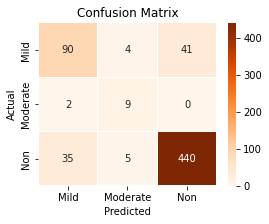

In [24]:
label_name = ['Mild', 'Moderate', 'Non']

# Build confusion matrix
cm = confusion_matrix(y_true,y_pred)
f, ax = plt.subplots(figsize=(4,3))
sn.heatmap(cm,  annot=True, fmt="d" ,cmap="Oranges", linewidths=0.01, xticklabels=label_name, yticklabels=label_name)
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [25]:
print(classification_report(y_true, y_pred, target_names=label_name, digits = 4))

              precision    recall  f1-score   support

        Mild     0.7087    0.6667    0.6870       135
    Moderate     0.5000    0.8182    0.6207        11
         Non     0.9148    0.9167    0.9157       480

    accuracy                         0.8610       626
   macro avg     0.7078    0.8005    0.7411       626
weighted avg     0.8630    0.8610    0.8612       626



In [27]:
# Save model
torch.save(model, "Swin-B_86%.pt" )